In [63]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from itertools import cycle
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler

# New section

In [3]:
train_loc = './train'
val_loc = './val'
test_loc = './test'

In [4]:
BATCH_SIZE = 32

In [5]:
trdata = ImageDataGenerator(rescale=1./255)
try:
    train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224), batch_size=BATCH_SIZE, shuffle=True, seed=42)
except FileNotFoundError:
    print(f"Error: Directory not found - {train_loc}")

Found 4388 images belonging to 3 classes.


In [6]:
vdata = ImageDataGenerator(rescale=1./255)
try:
    val_data = vdata.flow_from_directory(directory=test_loc, target_size=(224,224), batch_size=BATCH_SIZE, shuffle=True, seed=42)
except FileNotFoundError:
    print(f"Error: Directory not found - {val_loc}")

Found 235 images belonging to 3 classes.


In [7]:
counter = Counter('./')
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}

In [8]:
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [9]:
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

In [10]:
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=conv_base.input, outputs=output_layer)

In [11]:
def create_vgg16_model(input_shape, n_classes, optimizer):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=conv_base.input, outputs=output_layer)
    return model

In [15]:
input_shape = (224, 224, 3)
n_classes = 2
optimizer = tf.keras.optimizers.Adam()
model = create_vgg16_model(input_shape, n_classes, optimizer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,186 (57.64 MB)

 Trainable params: 15,109,186 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
input_shape = (224, 224, 3)
opt = Adam(learning_rate=0.00001)
n_classes = len(train_data.class_indices)

In [18]:
model = create_vgg16_model(input_shape, n_classes, opt)

In [19]:
checkpoint = ModelCheckpoint("vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

In [71]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_loc,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_loc,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_loc,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 4388 images belonging to 3 classes.
Found 311 images belonging to 3 classes.
Found 235 images belonging to 3 classes.


In [22]:
dataset_folder_path = './'
if os.path.exists(dataset_folder_path):
    print(f"Contents of {dataset_folder_path}:")
    print(os.listdir(dataset_folder_path))
else:
    print(f"Folder {dataset_folder_path} does not exist.")

Contents of ./:
['.DS_Store', 'Copy_of_Modified_Another_copy_of_Updated_code_file.ipynb', 'test', 'checkpoints_tf', 'new_model.ipynb', 'train', '.ipynb_checkpoints', 'breast_cancer.ipynb', 'val']


In [24]:
train_data_dir = 'train'
if os.path.exists(train_data_dir):
    print(f"Directory exists: {train_data_dir}")
    print("Contents:", os.listdir(train_data_dir))
else:
    print(f"Directory not found: {train_data_dir}")

Directory exists: train
Contents: ['.DS_Store', 'malignant', 'benign', 'normal']


In [27]:
checkpoint = ModelCheckpoint("vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

In [29]:
checkpoint_dir = 'checkpoints_tf'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = tf.train.Checkpoint(optimizer=opt, model=model)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, checkpoint_dir, max_to_keep=5  # Keep last 5 checkpoints
)

# First Time use following line of code
### No need after code break

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # To prevent overfitting
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: benign, malignant, normal
])

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Break the check points

In [75]:
if checkpoint_manager.latest_checkpoint:
    print(f"Restoring from {checkpoint_manager.latest_checkpoint}")
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

Restoring from checkpoints_tf/ckpt-20


In [76]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # Flatten the 28x28 image
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (example)
train_data = train_data.reshape((60000, 28, 28, 1))
test_data = test_data.reshape((10000, 28, 28, 1))
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Continue training
history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    initial_epoch=0,
    validation_data=(test_data, test_labels),
    callbacks=[CustomCheckpointCallback(), early_stop]
)

Epoch 1/25


/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 140s 975ms/step - accuracy: 0.3753 - loss: 1.0929 - val_accuracy: 0.3611 - val_loss: 1.0931
Epoch 2/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3750 - loss: 0.9963 - val_accuracy: 0.2609 - val_loss: 1.0140
Epoch 3/25


2024-10-12 16:41:44.574767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/hassanazhar/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-12 16:41:44.714809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


137/137 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.4655 - loss: 1.0208 - val_accuracy: 0.5382 - val_loss: 0.9778
Epoch 4/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5312 - loss: 0.8982 - val_accuracy: 0.5652 - val_loss: 1.0456
Epoch 5/25


2024-10-12 16:45:12.323489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-12 16:45:12.481315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


137/137 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.5228 - loss: 0.9630 - val_accuracy: 0.5000 - val_loss: 1.1453
Epoch 6/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 1.0517 - val_accuracy: 0.3043 - val_loss: 1.1939
Epoch 7/25


2024-10-12 16:48:58.426923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-12 16:48:58.584121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


137/137 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5823 - loss: 0.8870 - val_accuracy: 0.6632 - val_loss: 0.8378
Epoch 8/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 0.8433 - val_accuracy: 0.7391 - val_loss: 0.7419
Epoch 9/25


2024-10-12 16:52:49.682780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-12 16:52:49.857123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


137/137 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.6289 - loss: 0.8369 - val_accuracy: 0.7292 - val_loss: 0.7111
Epoch 10/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.8677 - val_accuracy: 0.6957 - val_loss: 0.6873
Epoch 11/25


2024-10-12 16:56:53.778714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-12 16:56:53.941224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


133/137 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6479 - loss: 0.7984

KeyboardInterrupt: 

In [36]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [40]:
test_data = test_data.reshape((-1, 28, 28, 1))
STEP_SIZE_TEST = len(test_labels) // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_data[:len(test_labels)], test_labels, steps=STEP_SIZE_TEST)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9713 - loss: 0.1340
Test Loss: 0.10762641578912735
Test Accuracy: 0.975600004196167


2024-10-12 14:50:30.623139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [43]:
STEP_SIZE_TEST = test_data.shape[0] // BATCH_SIZE
if test_data.shape[0] % BATCH_SIZE != 0:
    STEP_SIZE_TEST += 1

In [44]:
predictions = model.predict(test_data, steps=STEP_SIZE_TEST)
predicted_classes = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


In [66]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


In [67]:
predicted_classes

30

In [68]:
true_classes = test_labels[:len(predicted_classes)]
class_labels = [str(i) for i in range(10)]
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

TypeError: object of type 'numpy.int64' has no len()

In [46]:
predicted_classes

array([7, 2, 1, ..., 4, 5, 6])

# Assuming you have already calculated the confusion matrix `cm` and `true_classes` and `predicted_classes`


In [48]:
class_labels = [str(i) for i in range(10)]

In [49]:
class_labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [52]:
test_image_path = '/Users/hassanazhar/Python/tensorflow_image/test/benign/benign (332).png'

In [55]:
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [61]:
class_labels = ['benign', 'malignant', 'normal']
predicted_label = class_labels[predicted_classes]

TypeError: only integer scalar arrays can be converted to a scalar index

In [65]:
print(predicted_classes)

[7 2 1 ... 4 5 6]


In [64]:
scaler = StandardScaler()

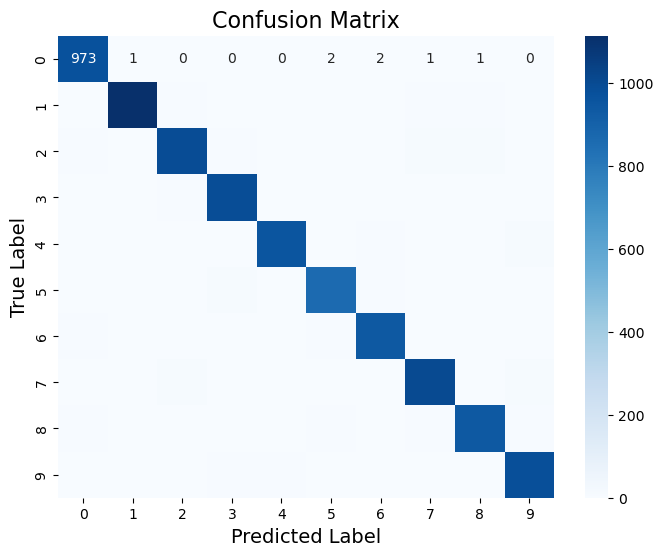

In [51]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# **1. SVM Classifier**


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reshape train_data and test_data before fitting and predicting
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

# SVM classifier
svm_clf = svm.SVC(kernel='linear', probability=True) # You can change the kernel, e.g., 'rbf', 'poly'
svm_clf.fit(train_data, train_labels)

# Predict using SVM
svm_pred = svm_clf.predict(test_data)

# Predict probabilities
svm_prob = svm_clf.predict_proba(test_data)

# Classification report
print("SVM Classification Report:")
print(classification_report(test_labels, svm_pred))

# Confusion Matrix
svm_cm = confusion_matrix(test_labels, svm_pred)

# Plotting the confusion matrix for SVM
plt.figure(figsize=(8,6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize # Removed extra indentation

# Binarize the labels for multiclass ROC AUC calculation
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], svm_prob[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot the ROC curves (example for one class)
plt.figure()
plt.plot(fpr_svm[0], tpr_svm[0], label='ROC curve (area = %0.2f)' % roc_auc_svm[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# **2. K-Nearest Neighbors (KNN) Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5) # You can change n_neighbors based on your data
knn_clf.fit(train_data, train_labels)

# Predict using KNN
knn_pred = knn_clf.predict(test_data)

# Classification report
print("KNN Classification Report:")
print(classification_report(test_labels, knn_pred))

# Confusion Matrix
knn_cm = confusion_matrix(test_labels, knn_pred)

# Plotting the confusion matrix for KNN
plt.figure(figsize=(8,6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# ROC CURVE


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multiclass ROC AUC calculation
test_labels_bin = label_binarize(test_labels, classes=np.unique(test_labels))

# Calculate ROC curve and AUC for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = test_labels_bin.shape[1]

for i in range(n_classes):
    knn_prob_class_i = knn_clf.predict_proba(test_data)[:, i]  # Probability for class i
    fpr_knn[i], tpr_knn[i], _ = roc_curve(test_labels_bin[:, i], knn_prob_class_i)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot ROC curves for each class (example for one class)
# Replace plot_roc_curve with your actual plotting function
# plot_roc_curve(fpr_knn[0], tpr_knn[0], roc_auc_knn[0], 'KNN - Class 0')

# ... (Similarly plot for other classes) ...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# ... (your existing code from ipython-input-55-a1d1401d8c5a) ...

# Function to plot ROC curve (modified)
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    """
    Plots the ROC curve for a given model.

    Args:
        fpr (dict): False positive rates for each class.
        tpr (dict): True positive rates for each class.
        roc_auc (dict): AUC values for each class.
        model_name (str): Name of the model for the plot title.
    """

    n_classes = len(fpr) # Get number of classes

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i])
        display.plot(ax=plt.gca(), name=f'{model_name} - Class {i}') # Plot on current axes

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# Call the function with the calculated values
plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, 'KNN')

# **3. Naive Bayes Classifier:**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(train_data, train_labels)

# Predict using Naive Bayes
nb_pred = nb_clf.predict(test_data)

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(test_labels, nb_pred))

# Confusion Matrix
nb_cm = confusion_matrix(test_labels, nb_pred)

# Plotting the confusion matrix for Naive Bayes
plt.figure(figsize=(8,6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Calculate accuracy scores for each classifier
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
nb_acc = accuracy_score(test_labels, nb_pred)

# Accuracy comparison plot
classifiers = ['SVM', 'KNN', 'Naive Bayes']
accuracies = [svm_acc, knn_acc, nb_acc]

plt.figure(figsize=(8,6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of SVM, KNN, and Naive Bayes')
plt.show()


# ROC CURVE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB

# Assuming train_data, train_labels, test_data, and test_labels are already defined

# Reshape train_data and test_data before fitting and predicting
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

# Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(train_data, train_labels)

# Predict probabilities
nb_prob = nb_clf.predict_proba(test_data)

# Binarize the labels for multiclass ROC AUC calculation
y_test_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_test_bin[:, i], nb_prob[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# ... (your existing code from ipython-input-55-a1d1401d8c5a) ...

# Function to plot ROC curve (modified)
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    """
    Plots the ROC curve for a given model.

    Args:
        fpr (dict or array-like): False positive rates for each class or a single class.
        tpr (dict or array-like): True positive rates for each class or a single class.
        roc_auc (dict or float): AUC values for each class or a single class.
        model_name (str): Name of the model for the plot title.
    """

    # Check if fpr is a dictionary (multi-class) or not (single-class)
    if isinstance(fpr, dict):
        n_classes = len(fpr)
        # Plot ROC curves for each class (multi-class case)
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i])
            display.plot(ax=plt.gca(), name=f'{model_name} - Class {i}')
    else:
        # Plot ROC curve for a single class (single-class case)
        plt.figure(figsize=(8, 6))
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot(ax=plt.gca(), name=model_name)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call the function with the calculated values
plot_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, 'Naive Bayes - Class 0')

# COMPARISON

In [ ]:
# Plot ROC curves for all classifiers
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'SVM')
plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, 'KNN')
plot_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, 'Naive Bayes')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM, KNN, and Naive Bayes')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate accuracy scores for each classifier
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
nb_acc = accuracy_score(test_labels, nb_pred)

# Accuracy comparison plot
classifiers = ['SVM', 'KNN', 'Naive Bayes']
accuracies = [svm_acc, knn_acc, nb_acc]

plt.figure(figsize=(8,6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of SVM, KNN, and Naive Bayes')
plt.show()


## Testing the Trained Model

In [ ]:
import os
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/saved_models/vgg16_model.keras'
model = load_model(model_path)

# Set the directory path for testing data
test_data_dir = '/content/drive/MyDrive/Training augmented/Validation'  # You can change this to training if needed

# Set your desired values for image width, height, and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create an ImageDataGenerator for the test data
datagen = ImageDataGenerator(rescale=1./255)  # Rescale as in training

# Load the validation data
test_data = datagen.flow_from_directory(
    test_data_dir,  # Change to 'train_data_dir' if you want to test on training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to avoid shuffling for correct evaluation
)

# Make predictions using the loaded model
predictions = model.predict(test_data, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

### Evaluation

In [ ]:
# Get the true labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  # Get class labels

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)


### Plotting confusion matrix

In [ ]:

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
